In [50]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [51]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [52]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [53]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/Users/pragathi.vetrivelmurugan/Desktop/TSAI/TSAI-Assignment-6/tsai_env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


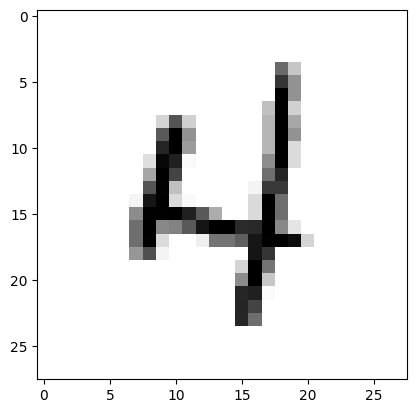

In [54]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


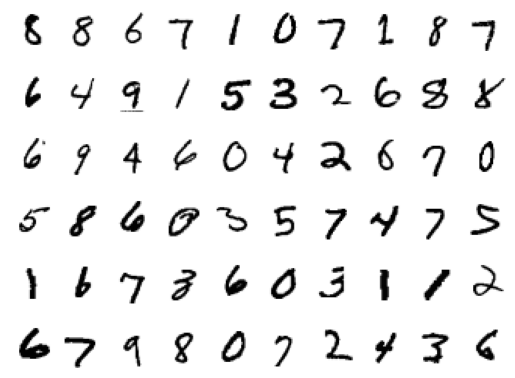

In [55]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### Model Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0),
            nn.ReLU()
        )# 26X26X32
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU()
        )# 24X24X64

        self.fc1 = nn.Linear(24*24*64, 1028)
        self.fc2 = nn.Linear(1028, 10)
        #self.fc2 = nn.Linear(10*10*1, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = x.view(-1, 24*24*64)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#### Model Summary

In [57]:
!pip install torchsummary tqdm
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
cpu
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Linear-5                 [-1, 1028]      37,897,220
            Linear-6                   [-1, 10]          10,290
Total params: 37,926,326
Trainable params: 37,926,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.90
Params size (MB): 144.68
Estimated Total Size (MB): 14

#### Model Training and Testing

In [58]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [59]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0023657511919736862 Batch_id=937 Accuracy=95.23: 100%|█| 938/938 [02:24<0




Test set: Average loss: 0.0561, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.003380001289770007 Batch_id=937 Accuracy=98.35: 100%|█| 938/938 [02:28<00




Test set: Average loss: 0.0404, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.005407964810729027 Batch_id=937 Accuracy=98.85: 100%|█| 938/938 [02:16<00




Test set: Average loss: 0.0387, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.010393925942480564 Batch_id=937 Accuracy=99.10: 100%|█| 938/938 [02:15<00




Test set: Average loss: 0.0418, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.014830994419753551 Batch_id=937 Accuracy=99.42: 100%|█| 938/938 [02:20<00




Test set: Average loss: 0.0429, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.0009368071332573891 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [02:18<0




Test set: Average loss: 0.0452, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.04085760936141014 Batch_id=937 Accuracy=99.68: 100%|█| 938/938 [02:31<00:




Test set: Average loss: 0.0436, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.006714309565722942 Batch_id=937 Accuracy=99.73: 100%|█| 938/938 [02:17<00




Test set: Average loss: 0.0454, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.005669977981597185 Batch_id=937 Accuracy=99.80: 100%|█| 938/938 [02:15<00




Test set: Average loss: 0.0496, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.0005120097193866968 Batch_id=937 Accuracy=99.87: 100%|█| 938/938 [02:21<0




Test set: Average loss: 0.0477, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.002046323847025633 Batch_id=937 Accuracy=99.92: 100%|█| 938/938 [02:14<00




Test set: Average loss: 0.0537, Accuracy: 9882/10000 (98.82%)

EPOCH: 11


Loss=0.0006758322706446052 Batch_id=937 Accuracy=99.97: 100%|█| 938/938 [02:16<0




Test set: Average loss: 0.0512, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=3.7735433124908013e-06 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18




Test set: Average loss: 0.0522, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=5.561587386182509e-06 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18<




Test set: Average loss: 0.0546, Accuracy: 9889/10000 (98.89%)

EPOCH: 14


Loss=0.0005918908282183111 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18<




Test set: Average loss: 0.0557, Accuracy: 9889/10000 (98.89%)



Selected random misclassified image with true label: 5
Image shape: torch.Size([1, 1, 28, 28])
convblock1 output shape: torch.Size([1, 32, 26, 26])
convblock2 output shape: torch.Size([1, 64, 24, 24])
fc1 output shape: torch.Size([1, 1028])
fc2 output shape: torch.Size([1, 10])
Predicted label: 3


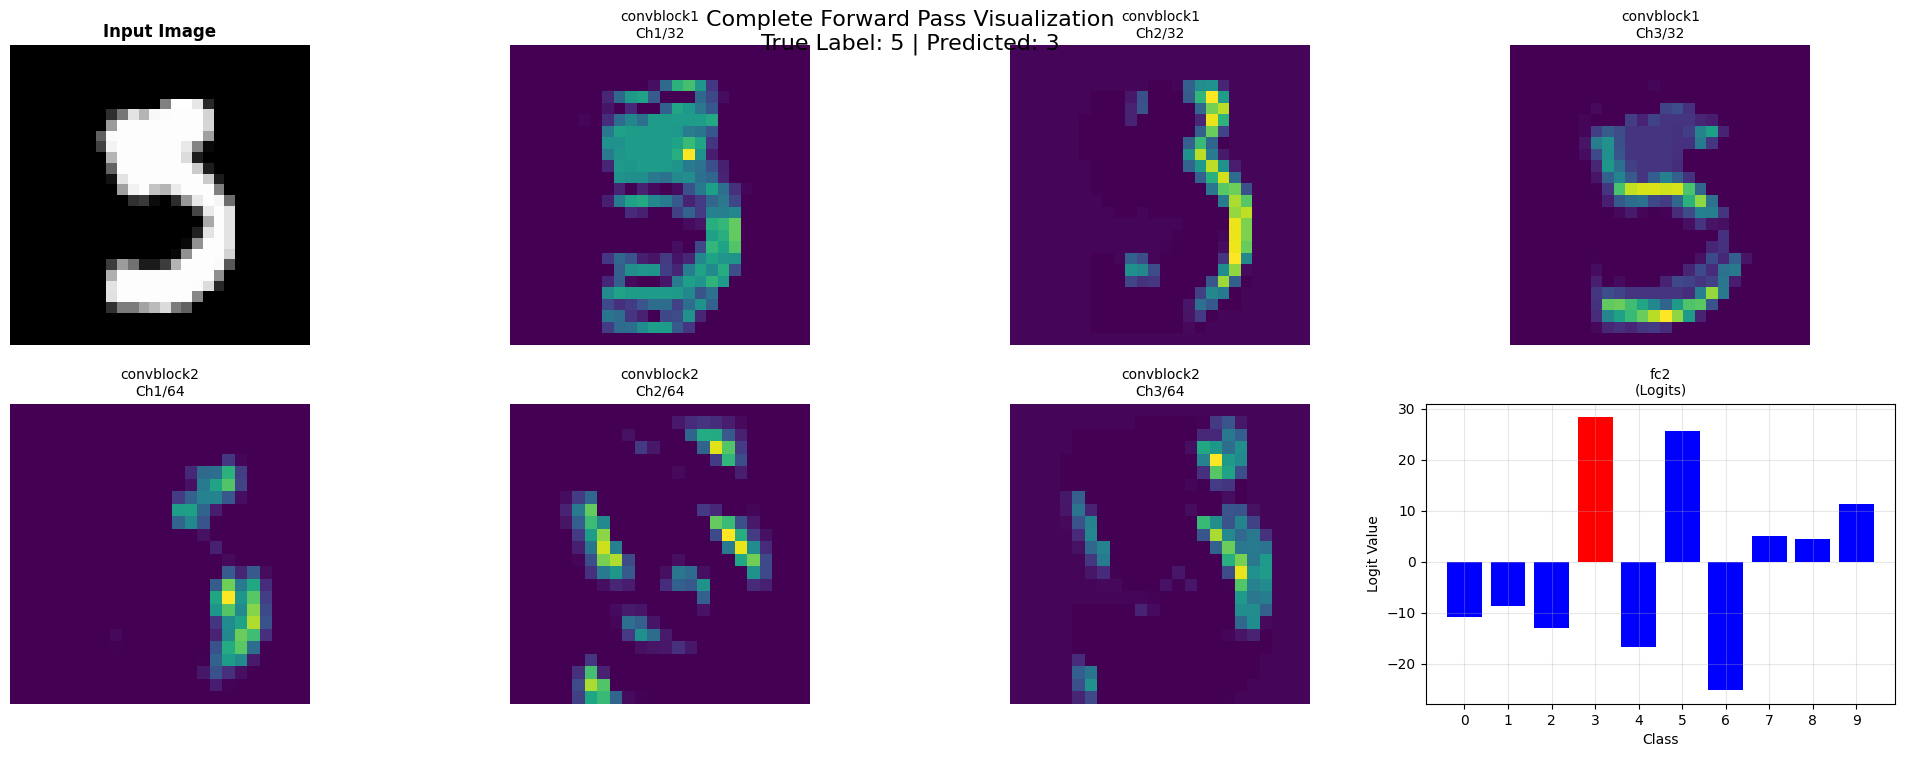


DETAILED LAYER OUTPUT STATISTICS

convblock1 (Conv Layer):
  Shape: torch.Size([1, 32, 26, 26])
  Mean activation: 0.2245
  Std activation: 0.5039
  Min: 0.0000, Max: 4.8425
  Sparsity (% zeros): 55.49%

convblock2 (Conv Layer):
  Shape: torch.Size([1, 64, 24, 24])
  Mean activation: 0.1100
  Std activation: 0.3754
  Min: 0.0000, Max: 5.9690
  Sparsity (% zeros): 80.47%

fc1 (Conv Layer):
  Shape: torch.Size([1, 1028])
  Mean activation: 0.0510
  Std activation: 1.0794
  Min: -3.7978, Max: 3.5695
  Sparsity (% zeros): 0.00%

fc2 (FC Layer):
  Shape: torch.Size([1, 10])
  Mean: 0.0520
  Std: 17.0554
  Min: -25.1792, Max: 28.3100
  Predicted class: 3 (logit: 28.3100)


In [63]:
# Visualize the complete forward pass through all layers
def visualize_complete_forward_pass(model, device, test_loader):
    """
    Choose a random misclassified image from test set and visualize outputs through all layers
    """
    model.eval()
    
    # Find a random misclassified sample
    sample_image = None
    true_label = None
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get indices of misclassified samples
                incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]
                
                # Choose a random one
                import random
                random_idx = random.choice(incorrect_indices.cpu().numpy())
                
                sample_image = data[random_idx:random_idx+1]
                true_label = target[random_idx].cpu().item()
                break
    
    if sample_image is None:
        print("No misclassified samples found in the test data!")
        return
    
    print(f"Selected random misclassified image with true label: {true_label}")
    print(f"Image shape: {sample_image.shape}")
    
    # Store outputs at each layer
    layer_outputs = {}
    layer_names = []
    
    # Manual forward pass to capture intermediate outputs
    with torch.no_grad():
        # Layer 1: convblock1
        x = model.convblock1(sample_image)
        layer_outputs['convblock1'] = x.cpu()
        layer_names.append('convblock1')
        print(f"convblock1 output shape: {x.shape}")
        
        # Layer 2: convblock2
        x = model.convblock2(x)
        layer_outputs['convblock2'] = x.cpu()
        layer_names.append('convblock2')
        print(f"convblock2 output shape: {x.shape}")
        
        # Layer 3: Flatten and fc1
        x_flat = x.view(-1, 24*24*64)
        x = model.fc1(x_flat)
        layer_outputs['fc1'] = x.cpu()
        layer_names.append('fc1')
        print(f"fc1 output shape: {x.shape}")

        x = model.fc2(x)
        layer_outputs['fc2'] = x.cpu()   
        layer_names.append('fc2')
        print(f"fc2 output shape: {x.shape}")     
        # Get prediction
        pred_label = x.argmax(dim=1).item()
        print(f"Predicted label: {pred_label}")
    
    # Create visualization
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'Complete Forward Pass Visualization\nTrue Label: {true_label} | Predicted: {pred_label}', 
                 fontsize=16, y=0.95)
    
    # Original image
    plt.subplot(4, 4, 1)
    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title('Input Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    subplot_idx = 2
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.squeeze().numpy()
        
        if layer_name == 'fc2':
            # For FC layer, show the 10 class logits as a bar chart
            plt.subplot(4, 4, subplot_idx)
            plt.bar(range(10), output_np, color=['red' if i == pred_label else 'blue' for i in range(10)])
            plt.title(f'{layer_name}\n(Logits)', fontsize=10)
            plt.xlabel('Class')
            plt.ylabel('Logit Value')
            plt.xticks(range(10))
            plt.grid(True, alpha=0.3)
            
        elif len(output.shape) == 4:  # Convolutional layers (batch, channels, height, width)
            batch_size, num_channels, height, width = output.shape
            
            # Show first few channels (up to 3) as individual feature maps
            channels_to_show = min(3, num_channels)
            
            for ch in range(channels_to_show):
                plt.subplot(4, 4, subplot_idx)
                plt.imshow(output_np[ch], cmap='viridis')
                plt.title(f'{layer_name}\nCh{ch+1}/{num_channels}', fontsize=10)
                plt.axis('off')
                subplot_idx += 1
                
                if subplot_idx > 16:  # Don't exceed subplot grid
                    break
            
            # If we have more channels, skip to next layer position
            if channels_to_show < num_channels and subplot_idx <= 16:
                subplot_idx += (3 - channels_to_show)
        
        if subplot_idx > 16:
            break
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each layer
    print("\n" + "="*60)
    print("DETAILED LAYER OUTPUT STATISTICS")
    print("="*60)
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.numpy()
        
        if layer_name == 'fc2':
            print(f"\n{layer_name} (FC Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean: {output_np.mean():.4f}")
            print(f"  Std: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Predicted class: {pred_label} (logit: {output_np[0, pred_label]:.4f})")
        else:
            print(f"\n{layer_name} (Conv Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean activation: {output_np.mean():.4f}")
            print(f"  Std activation: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Sparsity (% zeros): {(output_np == 0).mean() * 100:.2f}%")

# Call the function to visualize complete forward pass
visualize_complete_forward_pass(model, device, test_loader)